In [1]:
from util import list_correlations

import pandas as pd
import numpy as np

import math
from math import floor

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train_cleaned_basic.csv')
pd.DataFrame.sample(train_df, 1)

,passengerid,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,first_name,last_name,title
54,55,0,1,1,65.0,0,1,113509,61.9792,B30,C,Ostby,Engelhart Cornelius,mr


### Specify columns for analysis

In [3]:
use_col = ['passengerid', 'survived', 'pclass', 'sex', 'age', 'title']
df = train_df[use_col]

In [4]:
#Null values
df.isnull().sum()

passengerid      0
survived         0
pclass           0
sex              0
age            177
title            0
dtype: int64

In [5]:
age_null = df[df.age.isnull()].drop('age',axis=1).copy()
age_value = df[df.age.notnull()].copy()

age_value.age.info()

<class 'pandas.core.series.Series'>
Int64Index: 714 entries, 0 to 890
Series name: age
Non-Null Count  Dtype  
--------------  -----  
714 non-null    float64
dtypes: float64(1)
memory usage: 11.2 KB


--- 
### Age being treated as type float?

In [6]:
#Isolate problem age values
sorted([age for age in age_value.age if not age.is_integer()])

[0.42,
 0.67,
 0.75,
 0.75,
 0.83,
 0.83,
 0.92,
 14.5,
 20.5,
 23.5,
 24.5,
 28.5,
 28.5,
 30.5,
 30.5,
 32.5,
 32.5,
 34.5,
 36.5,
 40.5,
 40.5,
 45.5,
 45.5,
 55.5,
 70.5]

In [7]:
#Floor all floats
age_value.age = age_value.age.apply(math.floor)
age_value.age.info()

<class 'pandas.core.series.Series'>
Int64Index: 714 entries, 0 to 890
Series name: age
Non-Null Count  Dtype
--------------  -----
714 non-null    int64
dtypes: int64(1)
memory usage: 11.2 KB


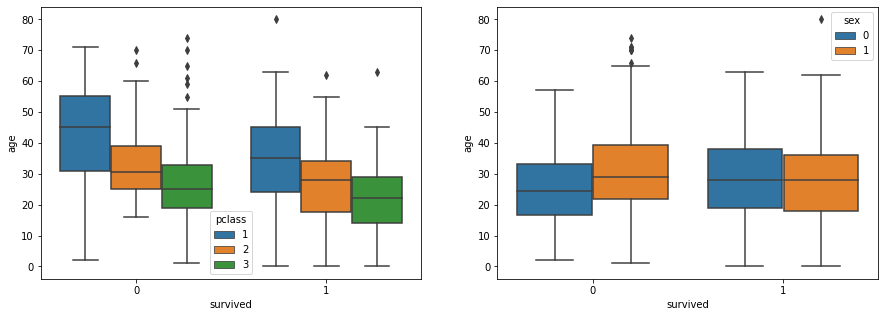

,survived,age,sex,pclass
mean,0.406162,29.679272,0.634454,2.236695
std,0.491460,14.536483,0.481921,0.838250
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,20.000000,0.000000,1.000000
50%,0.000000,28.000000,1.000000,2.000000
75%,1.000000,38.000000,1.000000,3.000000
max,1.000000,80.000000,1.000000,3.000000


In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.boxplot(data=age_value, y='age', x='survived', hue='pclass', ax=ax[0])
sns.boxplot(data=age_value, y='age', x='survived', hue='sex', ax=ax[1])
plt.show()

age_metrics = age_value[['survived', 'age', 'sex', 'pclass',]].describe().drop('count')
age_metrics

### Split data into seperate age groups for individual assessment

In [12]:
from util.cleaners import BasicCleaner

age_value_expanded = BasicCleaner.expand_age(age_value)
age_value_expanded.columns

Index(['passengerid', 'survived', 'pclass', 'sex', 'title', 'infant', 'child',
       'teen', 'young_adult', 'adult', 'age40+'],
      dtype='object')

In [75]:
age_increments = ['infant', 'child', 'teen', 'young_adult', 'adult', 'age40+',]

#dict{age_increment:DataFrame}
age_catagory_dict = dict.fromkeys(age_increments)
for catagory in age_catagory_dict.keys():
    age_catagory_dict[catagory] = age_value_expanded[age_value_expanded[catagory] == 1].drop(age_increments,
                                                                                             axis=1)
age_catagory_dict.keys()

dict_keys(['infant', 'child', 'teen', 'young_adult', 'adult', 'age40+'])

### Graphical representation of each age group

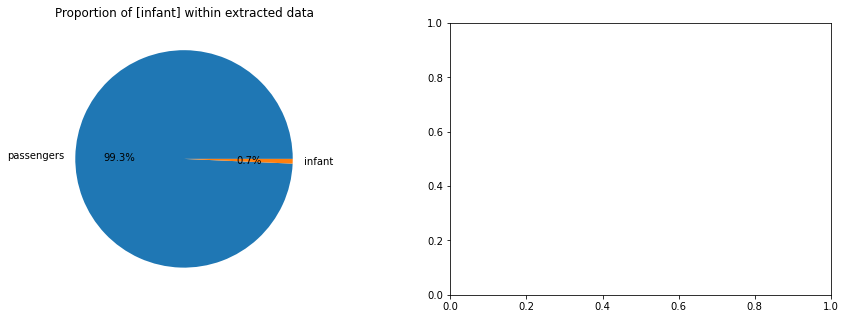

______________________________________________________________________________________________________


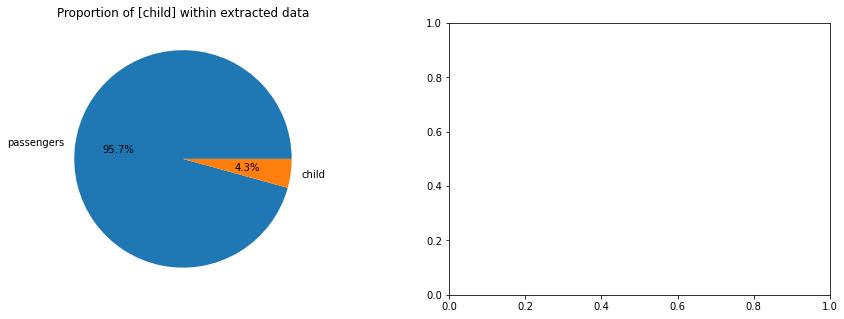

______________________________________________________________________________________________________


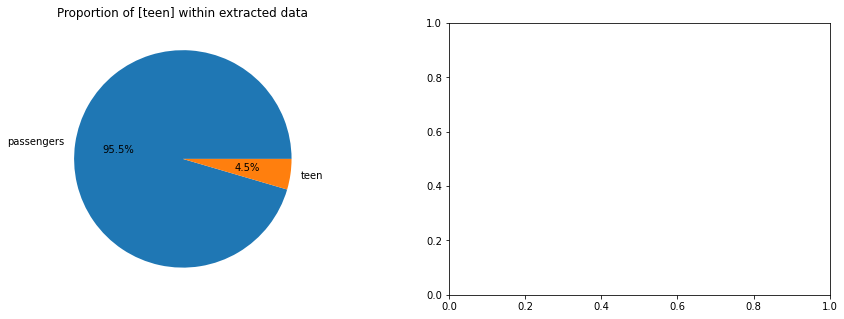

______________________________________________________________________________________________________


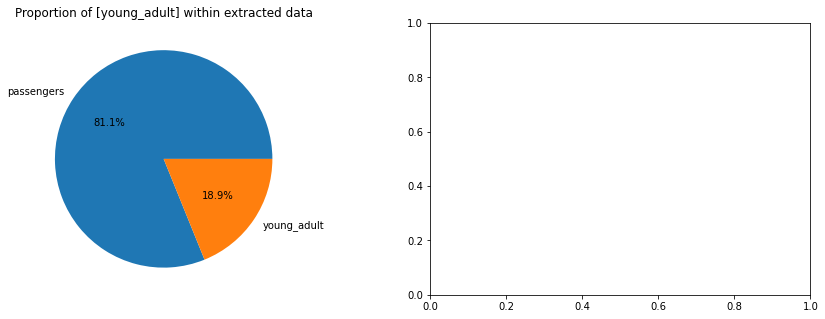

______________________________________________________________________________________________________


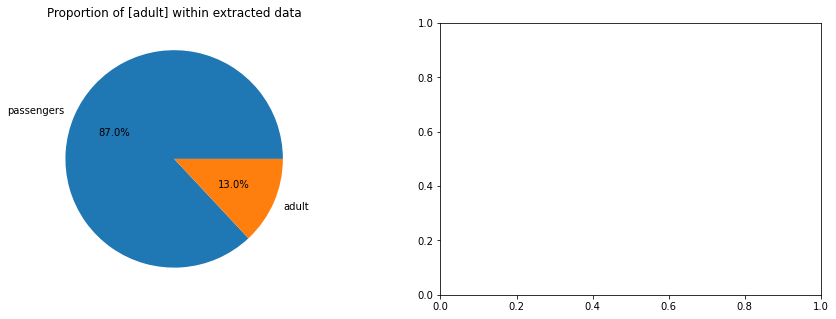

______________________________________________________________________________________________________


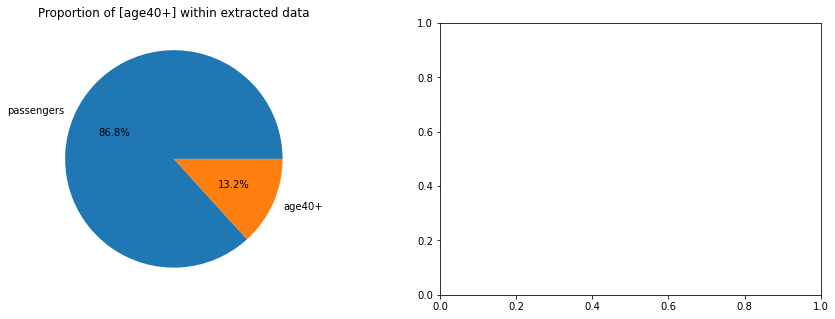

______________________________________________________________________________________________________


In [132]:
passengers = age_value_expanded.shape[0]

for catagory_name, data in age_catagory_dict.items(): 
    total = data.shape[0]
    males = data[data["sex"] == 1].shape[0]
    females = data[data["sex"] == 0].shape[0]
    survived = data[data["survived"] == 1].shape[0]
    died = data[data["survived"] == 0].shape[0]
    values = [males, females, survived, died]
        
    #Overall proportion
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].pie(x=[passengers, males], labels=["passengers", catagory_name], autopct="%.1f%%")
    ax[0].set_title(f"Proportion of [{catagory_name}] within extracted data")
    
#     ax[1].pie(values, labels=age_catagory_dict.keys())
    
    plt.show()
    print('______________________________________________________________________________________________________')

### Highest correlated features

In [144]:
age_value_corr = list_correlations(age_value)[[0,2,5]]
age_value_corr

survived  sex       0.538826
age       pclass    0.369450
survived  pclass    0.359653
dtype: float64

In [111]:
train_age.loc[(train_age.age < 18)&(train_age.title == 'mrs')]

,passengerid,survived,pclass,sex,age,title
9,10,1,2,0,14.0,mrs
307,308,1,1,0,17.0,mrs
781,782,1,1,0,17.0,mrs
830,831,1,3,0,15.0,mrs


### Preprocessing

In [44]:
train_age.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'title'], dtype='object')

In [129]:
transformer = ColumnTransformer([('one_hot', OneHotEncoder(), ['title']),
                                 ('standardize', StandardScaler(), ['pclass', 'sibsp', 'parch', 'fare'])],
                                 remainder='passthrough')


<AxesSubplot:>

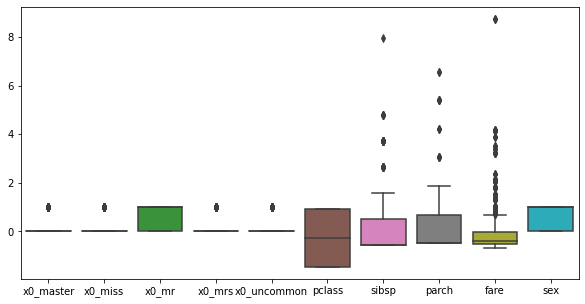

In [133]:
X = train_age.drop('age',axis=1)
y = [floor(age) for age in train_age['age']]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=22)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

# Get column names
columns = transformer.named_transformers_['one_hot'].get_feature_names()
columns = np.append(columns, ['pclass', 'sibsp', 'parch', 'fare', 'sex'])

# Convert to DataFrame
df = pd.DataFrame(X_train, columns=columns)

# Plot
fig = plt.figure(figsize=(10,5))
sns.boxplot(data=df)

In [191]:
def regression_results(predictions, actual):
    df = pd.DataFrame({'predictions':predictions,
                       'actual':actual})
    df['squared_differences'] = (df.actual - df.predictions) ** 2
    df['error_square_root'] = [math.sqrt(value) for value in df.squared_differences]
    return df

In [192]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression().fit(X_train, y_train)
predictions = clf.predict(X_test)

df = regression_results(predictions, y_test)

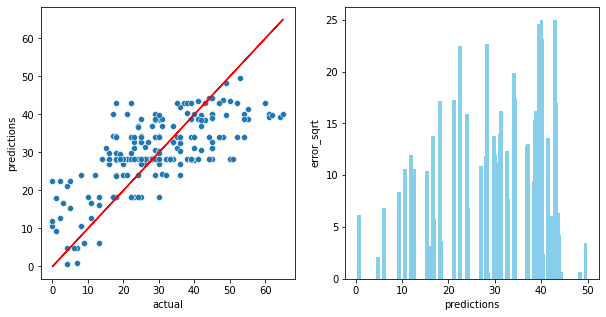

In [240]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(data=df, x='actual', y='predictions', ax=ax[0])
ax[0].plot(y_test,y_test, 'r')

ax[1].bar(df.predictions, df.error_square_root, color='skyblue')
ax[1].set_xlabel('predictions')
ax[1].set_ylabel('error_sqrt')

fig.subplots_adjust(wspace=0.2)

In [245]:
bad_pred = df[df.error_square_root > 15]
good_pred = df[df.error_square_root < 5]

In [258]:
bad_values

18    4
61    3
44    2
54    2
17    2
0     1
1     1
60    1
22    1
55    1
21    1
52    1
51    1
5     1
64    1
15    1
45    1
50    1
65    1
8     1
4     1
2     1
62    1
Name: actual, dtype: int64

<BarContainer object of 23 artists>

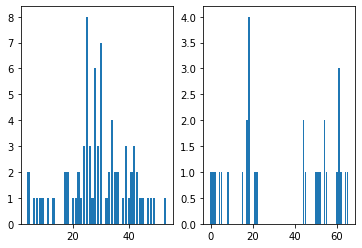

In [255]:
good_values = good_pred.actual.value_counts()
bad_values = bad_pred.actual.value_counts()

fig, ax = plt.subplots(1,2)
ax[0].bar(good_values.index, good_values.values)
ax[1].bar(bad_values.index, bad_values.values)